# Prepare Data

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as idisplay
import os
import sys
import errno
import random
import shutil
import fnmatch
import tensorflow as tf

from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, Input, Softmax
from keras_preprocessing.image import ImageDataGenerator
from keras.engine.saving import model_from_json
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils.vis_utils import plot_model

from sklearn.metrics import classification_report, confusion_matrix

from google.colab import files
from google.colab import drive

from pathlib import Path

In [2]:
drive.mount('/content/gdrive', force_remount=True)
iemocap = "gdrive/My Drive/Public/IEMOCAP_full_release"

Mounted at /content/gdrive


# GPU Utilization

In [ ]:
print("GPU Name: ", tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

GPU Name:  /device:GPU:0
Num GPUs Available:  1


# Transform Function
1. Get every audio by filename
2. Take the label from txt file
3. Convert Audio into Image
4. Iterate for 5 sessions

In [3]:
def getLabel(path, name):
  label_file = open(path, 'r')
  label_lines = label_file.readlines()

  line = [line for line in label_lines if name in line]
  line = line[0].replace(";", ":")
  label = line.split(":")[1]

  return label

def checkAndCreateDirectory(filename):
  if not os.path.exists(os.path.dirname(filename)):
    try:
        os.makedirs(os.path.dirname(filename))
    except OSError as exc: # Guard against race condition
        print(exc.errno)
        if exc.errno != errno.EEXIST:
            raise

def saveImage(path_audio, path_output, audio_name, label):
  audio_name = path_audio + audio_name + '.wav'
  audio_file, sample_rate = librosa.load(audio_name)

  # Tweak: Sample Rate
  # S = librosa.feature.mfcc(y=audio_file, sr=sample_rate) # Default 22_500
  S = librosa.feature.mfcc(y=audio_file, sr=48000)

  # TODO: Parameter MFCC, number of coefficient, Normalization
  # asd
  
  # Get Duration
  duration = librosa.get_duration(y=audio_file, sr=sample_rate)
  print(duration)

  # Plot into image
  # librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
  # librosa.display.specshow(librosa.power_to_db(S))
  # librosa.display.specshow(S)
  
  # Save into file
  # filename = path_output + label + "/" + audio_name + '.png'
  # checkAndCreateDirectory(filename)

  # plt.gca().set_axis_off()
  # plt.savefig(filename, dpi=100, bbox_inches='tight',pad_inches=0)
  # plt.show()
  # plt.clf()
  # plt.close('all')

def readAudioList(path_label, path_audio, path_output, recording, audio_list):
  print("Progress.. Audio ")

  for audio_name in audio_list:
    print(audio_name[-4:], end=' ')
    recordings = [file.name for file in os.scandir(path_audio)]
    
    label_file = [file.name for file in os.scandir(path_label) if recording in file.name]
    label_file = [filename for filename in label_file if '.txt' in filename][0]
    label_title = getLabel(path_label + label_file, audio_name)

    saveImage(path_audio, path_output, audio_name, label_title)

def deleteExtensions(audio_name):
  return audio_name.replace(".wav", "")

def transformAllSessions():
  sessions = ["3"]

  for session in sessions:
    print("\nProgress.. Session " + session)

    path_output = '/content/test/Session' + session + '/categorical/'
    path_audio = iemocap + '/Session' + session + '/sentences/wav/'
    path_label = iemocap + '/Session' + session + '/dialog/EmoEvaluation/Categorical/'

    recordings = [file.name for file in os.scandir(path_audio)]
    recordings.sort()

    for recording in recordings:
      print("\n\nProgress.. Recording " + recording + "\n")

      path_audio = iemocap + '/Session' + session + '/sentences/wav/'
      path_audio = path_audio + recording + "/"

      audio_list = [file.name for file in os.scandir(path_audio) if ".pk" not in file.name]
      audio_list = list(map(deleteExtensions, audio_list))
      audio_list.sort()
      
      readAudioList(path_label, path_audio, path_output, recording, audio_list)

def downloadLocalData():
  !zip -r /content/test.zip /content/test
  files.download("/content/test.zip")

def clearLocalFolder():
  !ls test
  !rm -rf test
  !rm test.zip

# clearLocalFolder()
# transformAllSessions()
# downloadLocalData()

# Retrieve data
Classification, 998 images of:
- Neutral state
- Happiness
- Anger
- Sadness

In [5]:
def clearData():
  !rm -rf "mfcc/train"
  !rm -rf "mfcc/test"
  !rm -rf "spectogram/test"
  !rm -rf "spectogram/test"
  !rm -rf "/content/content"

def splitData(path_input, path_output, category, filenames):
  sourcePath = path_input + "/" + category
  splitPercentage = int((len(filenames)+1) * .80)
  
  trainPath = path_output + "/train/" + category
  trainData = filenames[:splitPercentage]

  for trainFile in trainData:
    checkAndCreateDirectory(trainPath + "/" + trainFile)
    shutil.copyfile(sourcePath + "/" + trainFile, trainPath + "/" + trainFile)

  testPath = path_output + "/test/" + category
  testData = filenames[splitPercentage:]
  checkAndCreateDirectory(testPath)

  for testFile in testData:
    checkAndCreateDirectory(testPath + "/" + testFile)
    shutil.copyfile(sourcePath + "/" + testFile, testPath + "/" + testFile)

def getRandomData(feature):
  dataset = iemocap + "/Images/"
  categories = ["Neutral state", "Happiness", "Anger", "Sadness"]

  for category in categories:
    path = dataset + feature + "/" + category
    filenames = random.sample(os.listdir(path), 998)
    splitData(dataset + feature, feature, category, filenames)

def exportDataset():
  !zip -r mfcc/mfcc.zip mfcc
  shutil.copyfile("mfcc/mfcc.zip", iemocap + "/Images/export/mfcc.zip")

  !zip -r spectogram/spectogram.zip spectogram
  shutil.copyfile("spectogram/spectogram.zip", iemocap + "/Images/export/spectogram.zip")

def importDataset():
  # shutil.copyfile(iemocap + "/Images/export/mfcc.zip", "mfcc.zip")
  # !unzip mfcc.zip

  shutil.copyfile(iemocap + "/Images/export/spectogram.zip", "spectogram.zip")
  !unzip spectogram.zip

def importDurationed():
  shutil.copyfile(iemocap + "/Images/export/duration_second.zip", "duration_second.zip")
  !unzip duration_second.zip

  categories = ["neu", "hap", "ang", "sad"]

  for category in categories:
    path = "/content/content/transformed_image/" + category
    filenames = random.sample(os.listdir(path), 156)
    splitData("/content/content/transformed_image", "mfcc", category, filenames)

# clearData()
# getRandomData("mfcc")
# getRandomData("spectogram")

# exportDataset()
# importDataset()
# importDurationed()

# Preprocess

In [6]:
def save_model(model, filename):
  checkAndCreateDirectory("model/test.txt")
  with open("model/" + filename + ".json", "w") as json_file:
    model_json = model.to_json()
    json_file.write(model_json)

def load_model(struct, weight):
  json_file = open("model/" + struct + ".json", "r")
  loaded_model_json = json_file.read()
  json_file.close()

  loaded_model = model_from_json(loaded_model_json)
  loaded_model.load_weights("model/" + weight + ".hdf5")
  loaded_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

  return loaded_model

def load_data_mfcc():
  data_generator = ImageDataGenerator(validation_split=0.25)
  train_data = data_generator.flow_from_directory(
      directory="mfcc/train/",
      class_mode="categorical",
      subset="training",
      batch_size=1,
      shuffle=True,
      target_size=(256, 256)
  )

  validation_data = data_generator.flow_from_directory(
      directory="mfcc/train/",
      class_mode="categorical",
      subset="validation",
      batch_size=1,
      shuffle=True,
      target_size=(256, 256)
  )

  return train_data, validation_data

# def load_data_spectogram():
#   data_generator = ImageDataGenerator(validation_split=0.3)
#   train_data = data_generator.flow_from_directory(
#       directory="spectogram/train/",
#       class_mode="categorical",
#       subset="training",
#       batch_size=1,
#       shuffle=True,
#       target_size=(256, 256)
#   )
    
#   x_train = []
#   y_train = []

#   for i in range(train_data.__len__()):
#     a, b = train_data.next()
#     x_train.append(a[0])
#     y_train.append(b[0])

#   x_train = np.array(x_train)
#   y_train = np.array(y_train)


#   validation_data = data_generator.flow_from_directory(
#       directory="spectogram/train/",
#       class_mode="categorical",
#       subset="validation",
#       batch_size=1,
#       shuffle=True,
#       target_size=(256, 256)
#   )

#   x_val = []
#   y_val = []

#   for i in range(validation_data.__len__()):
#     a, b = validation_data.next()
#     x_val.append(a[0])
#     y_val.append(b[0])

#   x_val = np.array(x_val)
#   y_val = np.array(y_val)

#   return x_train, y_train, x_val, y_val

train_data, validation_data = load_data_mfcc()
# spectogram_x_train, spectogram_y_train, spectogram_x_val, spectogram_y_val = load_data_spectogram()

Found 376 images belonging to 4 classes.
Found 124 images belonging to 4 classes.


# Model

Model is builded
Model: "functional_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 127, 127, 32)      896       
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 63, 63, 64)        18496     
_________________________________________________________________
flatten_25 (Flatten)         (None, 254016)            0         
_________________________________________________________________
dense_181 (Dense)            (None, 128)               32514176  
_________________________________________________________________
dense_182 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_183 (Dense)            (None, 

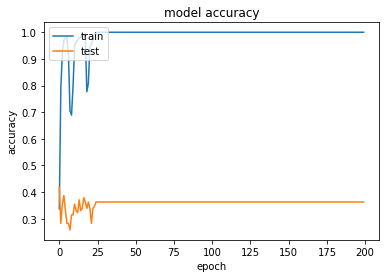

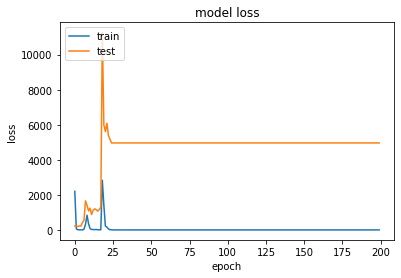

In [33]:
def plot_result(model, history):
  # list all data in history
  print(history.history.keys())

  # summarize history for accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

def build_convolution(model):
  model = Conv2D(32, kernel_size=3, strides=2)(model)
  model = Conv2D(64, kernel_size=3, strides=2)(model)

  return model

def build_model():

  mfcc_input = Input(shape=(256, 256, 3))
  mfcc_model = build_convolution(mfcc_input)

  # spectogram_input = Input(shape=(256, 256, 3))
  # spectogram_model = build_convolution(spectogram_input)

  # result_model = Sequential()
  # eff = tf.keras.applications.EfficientNetB3(
  #     weights=None,
  #     input_shape=(256,256,3)
  # )
  
  # result_model.add(eff)
  # result_model.add(Flatten())
  # result_model.add(Dense(4, activation='softmax'))

  # result_model = Concatenate()([mfcc_model])
  result_model = Flatten()(mfcc_model)

  result_model = Dense(128)(result_model)
  result_model = Dense(64)(result_model)
  result_model = Dense(32)(result_model)

  result_model = Dense(4, activation='softmax')(result_model)
  result_model = Model(inputs=[mfcc_input], outputs=[result_model])

  result_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

  save_model(result_model, "struct_model")
  result_model.summary()
  plot_model(result_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

  return result_model

def get_model():
  if os.path.isfile("/content/model/struct_model.json"):
    lastCheckpoint = sorted(Path("/content/model").iterdir(), key=os.path.getmtime)[-1].stem
    print("Model is " + lastCheckpoint)

    model = load_model("struct_model", lastCheckpoint)
    return model
  else:
    print("Model is builded")
    return build_model()

def train_model():
  checkAndCreateDirectory("/content/model/test.txt")

  for iteration in range(1):
    basepath = '/content/model/weight_model_' + str(iteration)
    best_checkpoint = ModelCheckpoint(basepath +'_{epoch:02d}_{loss:.2f}_{accuracy:.2f}_{val_loss:.2f}_{val_accuracy:.2f}.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='max', period=1)
    # callback_list = [best_checkpoint]

    model = get_model()
    history = model.fit_generator(
        generator=train_data,
        validation_data=validation_data,
        epochs=200,
        # callbacks=callback_list
    )

    plot_result(model, history)

  return model, history

!rm -rf /content/model
model, history = train_model()

# Evaluation

In [ ]:
test_generator = ImageDataGenerator()
test_data = test_generator.flow_from_directory(
    directory="mfcc/test/",
    batch_size=1,
    class_mode="categorical",
    shuffle=False,
    target_size=(256, 256)
)

loss, accuracy = model.evaluate_generator(generator=test_data)
print(
    ""
    "Prediction Loss: %2d\n"
    "Prediction Accuracy: %2d%%"
    ""
    % (loss, accuracy * 100))

Found 124 images belonging to 4 classes.
Prediction Loss: 9006
Prediction Accuracy: 28%


# Analysis

In [ ]:
target_names = ['Angry', 'Happy', 'Neutral', "Sad"]

Y_pred = model.predict_generator(test_data)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(test_data.classes, y_pred))

print('\n\nClassification Report')
print(classification_report(test_data.classes, y_pred, target_names=target_names))

Confusion Matrix
[[ 4  7 10 10]
 [ 2  9  5 15]
 [ 2 10  5 14]
 [ 1  5  8 17]]


Classification Report
              precision    recall  f1-score   support

       Angry       0.44      0.13      0.20        31
       Happy       0.29      0.29      0.29        31
     Neutral       0.18      0.16      0.17        31
         Sad       0.30      0.55      0.39        31

    accuracy                           0.28       124
   macro avg       0.30      0.28      0.26       124
weighted avg       0.30      0.28      0.26       124

